## Decoder-only architecture - GPT2

## 1. Introduction

For this exercise, we will focus on **decoder-only models**, particularly **GPT-2** (Generative Pre-trained Transformer 2), a model designed for text generation.

#### **Decoder-Only Models**
Decoder-only models, like GPT-2, differ from encoder-decoder models in that they generate text in a **unidirectional (left-to-right)** manner. These models do not have an encoder to process the entire input at once. Instead, they use **autoregressive** generation, predicting the next token based on the preceding context.

For the part of this lab, we will use `GPT2LMHeadModel`, a GPT-2 model with a language modeling head.

In [12]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
model_name = 'gpt2'

# TODO: Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### 1. **Embeddings Layer**
The embeddings layer creates initial representations of the input tokens, encoding both the meaning of the words and their positions within the sequence.

- **Word Embeddings** (`wte`): Maps each of the 50,257 vocabulary tokens into a 768-dimensional vector space.
- **Position Embeddings** (`wpe`): Adds positional information to the tokens using a learned embedding of size 1024 (representing the maximum sequence length) with 768 dimensions. This allows the model to understand the order of the tokens, as transformers do not have an inherent sense of position.

### 2. **Transformer Block (Decoder)**
The core of GPT-2 is composed of 12 identical **transformer blocks**, each consisting of several sub-components. These blocks are stacked to process the input text in a sequential, autoregressive manner.

Each transformer block includes the following:

- **Layer Normalization (ln_1, ln_2)**: Normalization is applied before both the attention mechanism and the feed-forward network to stabilize and speed up training. It ensures that the inputs to the layers have the same mean and variance, using learned parameters.

- **Self-Attention Mechanism**

  - **Self-Attention Mechanism (attn)**: GPT-2 uses masked self-attention to ensure that the model can only attend to tokens that have already been processed, preventing the model from "seeing" future tokens. This makes the model autoregressive.
    
    - **Query, Key, Value Projections**: The attention mechanism computes the **query (Q)**, **key (K)**, and **value (V)** vectors using **Conv1D layers** (`c_attn`). Notice that (1) when the kernel size is 1, the role of Conv1d is just to do a linear projection, and (2) that under the hood, the Conv1d used in HuggingFace is indeed just a linear projection (see code [here](https://github.com/huggingface/transformers/blob/53fad641cfdb5105e2470bcf3ef17ea8e25cc300/src/transformers/pytorch_utils.py#L87)). In other words, `c_attn` performs a linear transformation and covers the role of $W_q$, $W_k$, and $W_v$. All other operations using Conv1d will follow the same principle.

    - **Attention Output**: The output of the attention layer is passed through another **Conv1D layer** (`c_proj`) to project it back to the original 768-dimensional space.

- **Feed-Forward Neural Network (mlp)**
Each transformer block also contains a fully connected feed-forward neural network that processes the output of the attention mechanism. This is done in two stages:

  - **First Linear Transformation (`c_fc`)**: Expands the dimensionality from 768 to a larger intermediate size using a **Conv1D layer**.
    
  - **Activation Function (`act`)**: Applies the **GELU (Gaussian Error Linear Unit)** activation function, which introduces non-linearity and helps the model capture complex patterns in the data.

  - **Second Linear Transformation (`c_proj`)**: Projects the output back down from the intermediate size to 768 dimensions using another **Conv1D layer**.

- **Residual Connections**
  - GPT-2 uses skip connections around both the self-attention and feed-forward layers, where the input to each sub-layer is added to its output.

### 3. **Final Layer Normalization and Language Modeling Head**
- After passing through all 12 transformer blocks, a final **LayerNorm** (`ln_f`) is applied to normalize the output before it is passed to the language modeling head for token prediction.

- The output of the final transformer block is passed through a **linear layer** (`lm_head`) which maps the 768-dimensional hidden states to the vocabulary size (50,257). This step is essential for converting the hidden representations into predictions for the next token in the sequence.


In [13]:
# Set the model to evaluation mode
model.eval()

# Define the input prompt
prompt = "I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair."

# TODO: Tokenize the input prompt
input_ids = tokenizer.encode(prompt, return_tensors='pt')
# TODO: Autoregressively generate tokens (`max_length=200`, `do_sample=True`, `temperature=1.1`)
generated_ids = model.generate(input_ids.to(device), max_length=200, do_sample=True, temperature=1.1)
# TODO: Decode and print the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("Generated Text:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text:
I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair. What did I do to avoid the intrusion of a young man who is quite of an old age? For which reason I immediately felt more convinced, by his excellent insight into human nature in such a state. I told him I met in an alleyway one of the most magnificent places in London and he proceeded by his description of many beautiful old people. I was very pleased when I came to the street, which, as a rule, is one of the most peaceful places in London. He was very good-natured in English, and had the perfect knowledge of all subjects except economics; he did not shy away from talk of personal wealth, or of financial instruments, or of those with money; so that if I was found in the middle-of-throughest


## 2. Decoder (Masked) Self-Attention Mechanism

In this exercise, we will focus on the **masked self-attention mechanism** used in the decoder blocks of GPT-2. This mechanism allows the model to attend to previous tokens in an autoregressive manner, ensuring that the model generates text sequentially from left to right without looking ahead to future tokens.

A plot of the **self-attention matrix** for a single decoder block in GPT-2 is shown below. The matrix represents the attention weights between different tokens in the input sequence. The **x-axis** and **y-axis** correspond to the tokens in the input sequence. Each position on these axes represents a specific token in the input text.
  
#### **Masked Self-Attention Behavior:**
- As expected in a **decoder-only** model, we observe a clear triangular pattern. Tokens only attend to themselves and the tokens that precede them. For example, the first token (`I`) only attends to itself, the second token (`love`) attends to both itself and the first token, and so on.
- The upper-right part of the matrix is empty (dark purple), indicating that the model **masks future tokens** to prevent them from being used in generating the current token. This ensures that GPT-2 maintains its **autoregressive property**, where each token is generated based only on past tokens.

- In the image, you can see that certain tokens attend more strongly to previous tokens. For example, the token `favorite` attends heavily to earlier tokens like `Italian` and `food`, as indicated by the brighter colors in the heatmap.
- The model tends to attend more to the recent past tokens, which is crucial for maintaining context during text generation.


In [14]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns

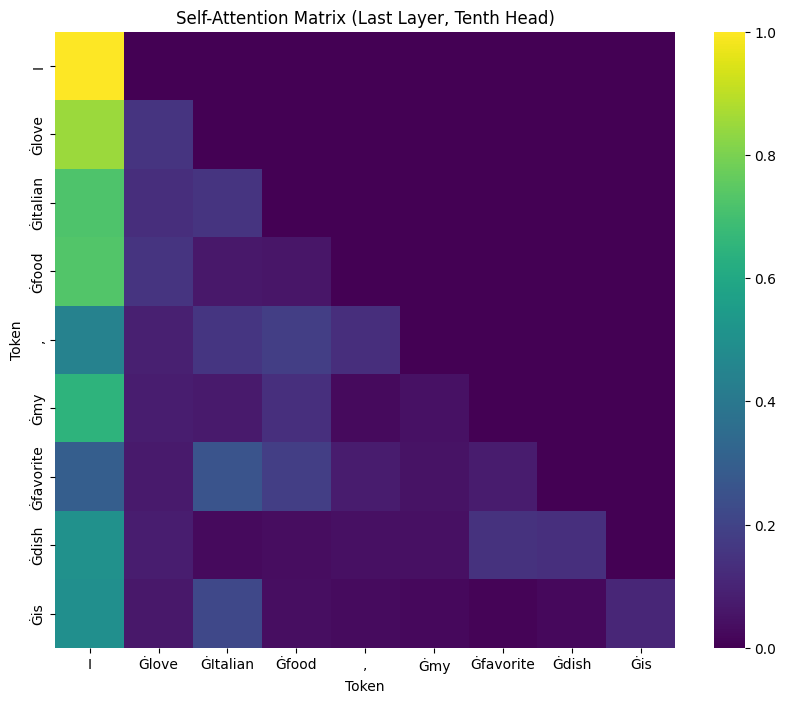

In [15]:
model_name = 'gpt2'
model = GPT2Model.from_pretrained(model_name, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Input prompt
prompt = "I love Italian food, my favorite dish is"

# TODO: Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors='pt')

with torch.no_grad():
    # TODO: Generate the model output and retrieve attention weights
    outputs = model(**inputs)
    attentions = outputs.attentions

# Visualize the attention weights from the last layer
attention_matrix = attentions[-1][0][10].cpu().numpy()  # Last layer, tenth head

# Get the tokens for the input prompt
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Plot the attention matrix (last layer, first head) with words as labels
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title('Self-Attention Matrix (Last Layer, Tenth Head)')
plt.xlabel('Token')
plt.ylabel('Token')
plt.show()

## 3. Positional Embedding

Similarly to what we have seen in the previous exercise (`01-bert`), GPT-2 uses **positional embeddings** to encode the position of tokens in the input sequence. These embeddings are added to the token embeddings to provide the model with information about the order of the tokens.

Also in GPT-2, the positional embeddings are learned during training, allowing the model to capture complex patterns in the data.

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

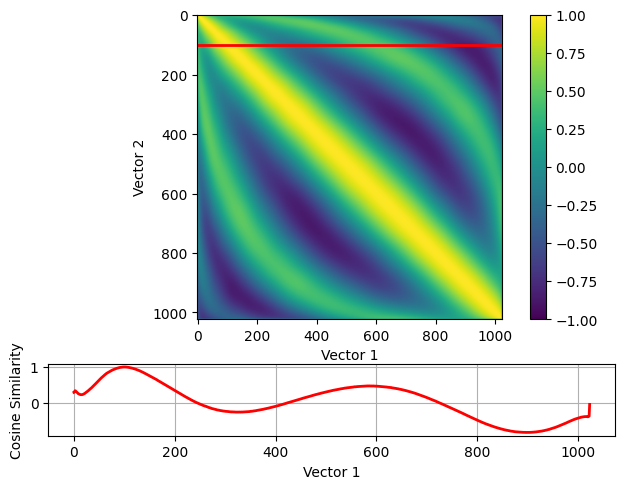

In [17]:
# Extract learned positional embeddings from the model
positional_embeddings = model.wpe.weight.detach().cpu().numpy()  # Shape: (1024, 768)

# TODO: Compute cosine similarity between positional embeddings
cosine_sim = cosine_similarity(positional_embeddings)

fig, ax = plt.subplot_mosaic("""
AAA
AAA
AAA
BBB""")

plt.tight_layout()

# Plot the cosine similarity heatmap
ax["A"].set_aspect('equal')
cbar = ax["A"].imshow(cosine_sim, cmap='viridis', vmin=-1, vmax=1)
ax["A"].set_xlabel('Vector 1')
ax["A"].set_ylabel('Vector 2')
ax["A"].axhline(100, c='r', lw=2)
# add colorbar
fig.colorbar(cbar, ax=ax["A"])


# Plot the cosine similarity for a specific row

ax["B"].plot(cosine_sim[100], c='r', lw=2)
ax["B"].set_xlabel('Vector 1')
ax["B"].set_ylabel('Cosine Similarity')
ax["B"].grid()

## 4. Sampling Methods

### **Implementing Sampling Methods:**

In this exercise, we will explore various **sampling methods** used for text generation in GPT-2. Each sampling method determines how the model selects the next token when generating text.

GPT-2 produces a probability distribution over possible tokens for each position in the sequence. The different sampling strategies allow us to choose how we sample from this distribution.

In [18]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [19]:
# TODO: Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the pad token to eos token
tokenizer.pad_token = tokenizer.eos_token

# Set the model to evaluation mode
model.eval()

# Input prompt
prompt = "I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair."

# TODO: Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors='pt')

1. **Greedy Sampling**: Always selects the token with the highest probability at each step.

In [20]:
# Greedy Sampling: Pick the token with the highest probability
def greedy_sampling(model, input_ids, max_length):
    input_ids = input_ids.to(device)
    for _ in range(max_length):
        # NOTE: There's no need to pass an attention mask, since we are passing a single
        # input sequence and the model will automatically create the mask.
        logits = model(input_ids=input_ids).logits[:, -1, :] # Compute the logits for the last token (1st batch)
        next_token = torch.argmax(logits, dim=1).unsqueeze(1) # Get the most likely next token
        input_ids = torch.hstack([input_ids, next_token]) # Add the token to the output sequence

        if next_token.item() == tokenizer.eos_token_id:
            break

    return input_ids

# Generate and return text using each sampling method
max_length = 100  # Max tokens to generate

# Greedy Sampling
input_length = inputs["input_ids"].shape[-1]
output_greedy = greedy_sampling(model, input_ids, max_length)
print(prompt)
print(tokenizer.decode(output_greedy[0, input_length:], skip_special_tokens=True))

I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 He was a very handsome man, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was


2. **Beam Search**: Expands multiple candidate sequences and selects the best based on their cumulative probabilities.

In [21]:
# Beam Search (simple version with fixed beam width)

# NOTE: each score is the log-probability of the sequence
# (remember, the sum of log-probabilities is the log-probability of the product)
# (i.e., of the entire sentence)
def beam_search(model, input_ids, max_length, beam_width=3):
    sequences = [(input_ids.to(device), 0)]  # (sequence, score)
    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            logits = model(seq).logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)
            top_k_probs, top_k_tokens = torch.topk(probs, beam_width, dim=-1) # Get top k tokens

            for i in range(beam_width):
                candidate_seq = torch.cat([seq, top_k_tokens[:, i].unsqueeze(-1)], dim=-1)  # Add token to sequence
                candidate = (candidate_seq, score - torch.log(top_k_probs[:, i]).item()) # Update score by adding -log(prob)
                all_candidates.append(candidate) # Add new candidate

        # Select top `beam_width` sequences
        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

        if sequences[0][0][0, -1].item() == tokenizer.eos_token_id:
            break

    return sequences[0][0]

# Beam Search
output_beam = beam_search(model, input_ids, max_length, beam_width=5)
print(prompt)
print(tokenizer.decode(output_beam[0, input_length:], skip_special_tokens=True))

KeyboardInterrupt: 

3. **Random Sampling**: Samples tokens randomly according to their probabilities.

In [ ]:
# Random Sampling: Randomly sample a token from the distribution
def random_sampling(model, input_ids, max_length):
    output = input_ids
    for _ in range(max_length):
        #TODO: Compute the logits
        logits = model(output).logits[:,-1,:]

        #TODO: Sample a token from the probability distribution (hint: use torch.multinomial)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs.squeeze(),num_samples=1)

        #TODO: Update the output and attention mask
        output = torch.cat([output, next_token.unsqueeze(-1)], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Random Sampling
output_random = random_sampling(model, input_ids, max_length)
print(prompt)
print(tokenizer.decode(output_random[0, input_length:], skip_special_tokens=True))


4. **Top-k Sampling**: Samples only from the top `k` most probable tokens.

In [22]:
# Top-k Sampling: Sample from the top k tokens
def top_k_sampling(model, input_ids, max_length, k=50):
    output = input_ids
    for i in range(max_length):
        print(f'{i}/{max_length} Iteration')
        #TODO: Compute the logits
        logits = model(output).logits[:,-1,:]

        #TODO: Sample a token from the top k tokens (hint: use torch.topk and torch.multinomial)
        top_k_logits, top_k_tokens = torch.topk(logits, k=k)
        top_k_probs = F.softmax(top_k_logits, dim=-1)
        sampled_index = torch.multinomial(torch.arange(top_k_probs.shape[1], dtype=torch.float32), num_samples=1)
        next_token = top_k_tokens[0,sampled_index] # Select the sampled token

        #TODO: Update the output and attention mask
        output = torch.cat([output, next_token.unsqueeze(-1)], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Top-k Sampling
output_top_k = top_k_sampling(model, input_ids, max_length, k=50)
print(prompt)
print(tokenizer.decode(output_top_k[0, input_length:], skip_special_tokens=True))


0/100 Iteration
1/100 Iteration
2/100 Iteration
3/100 Iteration
4/100 Iteration
5/100 Iteration
6/100 Iteration
7/100 Iteration
8/100 Iteration
9/100 Iteration
10/100 Iteration
11/100 Iteration
12/100 Iteration
13/100 Iteration
14/100 Iteration
15/100 Iteration
16/100 Iteration
17/100 Iteration
18/100 Iteration
19/100 Iteration
20/100 Iteration
21/100 Iteration
22/100 Iteration
23/100 Iteration
24/100 Iteration
25/100 Iteration
26/100 Iteration
27/100 Iteration
28/100 Iteration
29/100 Iteration
30/100 Iteration
31/100 Iteration
32/100 Iteration
33/100 Iteration
34/100 Iteration
35/100 Iteration
36/100 Iteration
37/100 Iteration
38/100 Iteration
39/100 Iteration
40/100 Iteration
41/100 Iteration
42/100 Iteration
43/100 Iteration
44/100 Iteration
45/100 Iteration
46/100 Iteration
47/100 Iteration
48/100 Iteration
49/100 Iteration
50/100 Iteration
51/100 Iteration
52/100 Iteration
53/100 Iteration
54/100 Iteration
55/100 Iteration
56/100 Iteration
57/100 Iteration
58/100 Iteration
59/100 

5. **Top-p (Nucleus) Sampling**: Samples from the smallest set of tokens whose cumulative probability exceeds `p`.

In [28]:
# Top-p (Nucleus) Sampling: Sample from the smallest set of tokens whose cumulative probability exceeds p
def top_p_sampling(model, input_ids, max_length, p=0.9):
    output = input_ids.to(device)
    for _ in range(max_length):
        #TODO: Compute the logits
        logits = model(output).logits[:,-1,:]

        # TODO: create a mask to filter out tokens with cumulative probability above p (hint: use torch.sort and torch.cumsum)
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(logits, dim=-1), dim=-1) # Cumulative Distribution Function (CDF)
        top_p_indices = cumulative_probs <= p

        if top_p_indices.sum() == 0:  # Fix for when there are no valid top-p indices
            top_p_indices[0] = True  # Ensure at least one token is considered

        top_p_probs = F.softmax(sorted_logits[top_p_indices], dim=-1) # Recompute the probabilities
        sampled_index = torch.multinomial(top_p_probs, num_samples=1) # Sample from the updated distribution

        next_token = sorted_indices[top_p_indices][sampled_index]
        output = torch.cat([output, next_token.unsqueeze(0)], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Top-p (Nucleus) Sampling
output_top_p = top_p_sampling(model, input_ids, max_length, p=0.9)
print(prompt)
print(tokenizer.decode(output_top_p[0, input_length:], skip_special_tokens=True))






I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 He used to play with me when I was very young.

"I saw him there a few months ago," continued Holmes, "at the premiere night at Yale," when a drunken "young man" told him of the antics of a handsome professor in the old gold rush. Holmes thought it was a very pleasant man to accompany him to see him, and then promptly left me.

"Then that old man talked to Mr. Holmes about some topics which I had known him to know


In [29]:
len(input_ids[0])

44

6. **Temperature Scaling**: Adjusts the randomness of the token selection by scaling the probability distribution.

In [34]:
# Temperature Scaling: Adjust the randomness of predictions by scaling the logits
def temperature_sampling(model, input_ids, max_length, temperature=0.7):
    output = input_ids
    for _ in range(max_length):
        #TODO: Compute the logits
        logits = model(output).logits[:,-1,:]

        #TODO: Scale the logits by the temperature parameter and sample from the updated distribution
        logits = logits / temperature # Scale the logits by the temperature parameter
        probs = F.softmax(logits, dim=-1) # Compute the probabilities
        next_token = torch.multinomial(probs, num_samples=1) # Sample from the updated distribution

        #TODO: Update the output and attention mask
        output = torch.cat([output, next_token], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Temperature Sampling
print(prompt)
print()
print("Temperature 0.25")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=0.25)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 0.5")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=0.5)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 0.75")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=0.75)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 1.1")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=1.1)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 1.5")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=1.5)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))


I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.

Temperature 0.25
 He was in the middle of a long conversation with a very handsome young man, who was very much interested in the subject. He was very much interested in the subject of the young man's life, and he was very much interested in the subject of the young man's life. He was very much interested in the subject of the young man's life. He was very much interested in the subject of the young man's life. He was very much interested in the subject of the young man's life

Temperature 0.5
 I asked him if he knew any of the people who were at the funeral. He said that he did not and that he had never seen any of them. I asked him about the people who had been there, and he said that they had been quite well known to him. I asked him why he had not seen any of them, and he said that he had not

### **Using Pre-Implemented Sampling Methods**

The Hugging Face `transformers` library offers built-in implementations for a variety of sampling methods used in text generation , such as the one we have just implemented, through the `generate()` function.

In [35]:
# Function to generate text using various sampling methods
def generate_text(model, input_ids, max_length, method, **kwargs):

    methods = {
        "greedy": {},
        "beam": {"num_beams": kwargs.get('num_beams', 3), "early_stopping": True},
        "random": {"do_sample": True},
        "top_k": {"do_sample": True, "top_k": kwargs.get('top_k', 50)},
        "top_p": {"do_sample": True, "top_p": kwargs.get('top_p', 0.9)},
        "temperature": {"do_sample": True, "temperature": kwargs.get('temperature', 0.7)}
    }
    return model.generate(input_ids.to(device), max_length=max_length, pad_token_id=tokenizer.eos_token_id, **methods[method])

# Generate text using each sampling method
max_length = 200  # Increased max_length to generate more tokens

# Get the length of the input prompt in tokens
input_length = len(tokenizer.encode(prompt, add_special_tokens=False))

# Greedy Sampling
output_greedy = generate_text(model, inputs['input_ids'], max_length, 'greedy')
print("Greedy Sampling:")
print(tokenizer.decode(output_greedy[0, input_length:], skip_special_tokens=True))


# Beam Search
output_beam = generate_text(model, inputs['input_ids'], max_length, 'beam', num_beams=5)
print("\nBeam Search:")
print(tokenizer.decode(output_beam[0, input_length:], skip_special_tokens=True))

# Random Sampling
output_random = generate_text(model, inputs['input_ids'], max_length, 'random')
print("\nRandom Sampling:")
print(tokenizer.decode(output_random[0, input_length:], skip_special_tokens=True))

# Top-k Sampling
k = 50
output_top_k = generate_text(model, inputs['input_ids'], max_length, 'top_k', top_k=k)
print(f"\nTop-{k} Sampling:")
print(tokenizer.decode(output_top_k[0, input_length:], skip_special_tokens=True))

# Top-p (Nucleus) Sampling
p = 0.9
output_top_p = generate_text(model, inputs['input_ids'], max_length, 'top_p', top_p=p)
print(f"\nTop-{p} (Nucleus) Sampling:")
print(tokenizer.decode(output_top_p[0, input_length:], skip_special_tokens=True))

# Temperature Scaling
temperature = 0.7
output_temperature = generate_text(model, inputs['input_ids'], max_length, 'temperature', temperature=temperature)
print(f"\nTemperature Sampling ({temperature}):")
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))



Greedy Sampling:
 He was a very handsome man, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed

Beam Search:
 He told me that he had come to see me, and that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see m